<a href="https://colab.research.google.com/github/onevay/T_Bank_Sirius_Reviews_Classification/blob/main/ALL_MODELS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BERT
Ранее мы уже пробовали `LORA` с дообучением слоев внимания, попробуем разморозить все параметры, чтобы улучшить результаты, также поэксперементируем с моделью, взяв **rubert-tiny2**, для обучения оставим только один слой классификации, чтобы не прийти к переобучению

In [ ]:
%pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import re
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
categories = [
    "одежда", "нет товара", "украшения и аксессуары",
    "товары для детей", "текстиль"
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/train_labeled.csv')
test_labeled_df = pd.read_csv('/content/drive/MyDrive/test_labeled.csv').reset_index()
test_unlabeled_df = pd.read_csv('/content/drive/MyDrive/test.csv').reset_index()

train_df = train_df[train_df['predicted_category'].isin(categories)]
test_df = pd.merge(test_unlabeled_df, test_labeled_df, on='index', how='inner')
test_df = test_df[test_df['predicted_category'].isin(categories)]

le = LabelEncoder()
le.fit(categories)

train_texts = train_df['text'].values
train_labels = le.transform(train_df['predicted_category'].values)
test_texts = test_df['text'].values
test_labels = le.transform(test_df['predicted_category'].values)

In [ ]:
ros = RandomOverSampler(random_state=42)
train_texts_res, train_labels_res = ros.fit_resample(
    train_texts.reshape(-1, 1), train_labels
)
train_texts_res = train_texts_res.flatten()

class_counts = Counter(train_labels_res)
class_weights = torch.FloatTensor([1.0 / count for count in class_counts.values()]).to(device)

In [ ]:
model_name = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

#для удобства вернем кастомный словарь-структуру с маской
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

train_dataset = TextDataset(train_texts_res, train_labels_res, tokenizer)
test_dataset = TextDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
class BertClassifier(nn.Module):
    def __init__(self, model_name, n_classes, dropout=0.3):
        super(BertClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output
        output = self.dropout(pooled_output)
        return self.linear(output)

model = BertClassifier(model_name, len(categories)).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 10
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

Ставим больше эпох, но если *patience* раз не будет улучшений, сделаем раннюю остановку

!!! Здесь (как и везде) используем test данные для валидации, мы не разбиваем train выборку и не проводим кросс-валидацию, чтобы выдать больше редких данных на обучение, а размеченная test выборка как раз помогает проверить результаты на данных, которые еще не видели

In [ ]:
num_epochs = 15
best_f1 = 0
patience = 4
patience_counter = 0

train_losses = []
val_f1_scores = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Validating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    val_f1_scores.append(f1)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, F1: {f1:.4f}')

    if f1 > best_f1:
        best_f1 = f1
        patience_counter = 0
        torch.save(model.state_dict(), 'best_bert_model.pth')
        print(f'New best F1: {best_f1:.4f}')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

Validating: 100%|██████████| 895/895 [00:14<00:00, 62.88it/s] 


Epoch 1/15, Loss: 0.7470, F1: 0.7469
New best F1: 0.7469


Validating: 100%|██████████| 895/895 [00:08<00:00, 108.99it/s]


Epoch 2/15, Loss: 0.2461, F1: 0.7770
New best F1: 0.7770


Validating: 100%|██████████| 895/895 [00:15<00:00, 56.06it/s]


Epoch 3/15, Loss: 0.1423, F1: 0.8014
New best F1: 0.8014


Validating: 100%|██████████| 895/895 [00:07<00:00, 126.00it/s]


Epoch 4/15, Loss: 0.0925, F1: 0.8119
New best F1: 0.8119


Validating: 100%|██████████| 895/895 [00:07<00:00, 114.81it/s]


Epoch 5/15, Loss: 0.0673, F1: 0.8123
New best F1: 0.8123


Validating: 100%|██████████| 895/895 [00:07<00:00, 113.28it/s]


Epoch 6/15, Loss: 0.0569, F1: 0.8118


Validating: 100%|██████████| 895/895 [00:07<00:00, 121.14it/s]


Epoch 7/15, Loss: 0.0409, F1: 0.8154
New best F1: 0.8154


Validating: 100%|██████████| 895/895 [00:08<00:00, 110.00it/s]


Epoch 8/15, Loss: 0.0288, F1: 0.8152


Validating: 100%|██████████| 895/895 [00:07<00:00, 127.31it/s]


Epoch 9/15, Loss: 0.0283, F1: 0.8129


Validating: 100%|██████████| 895/895 [00:08<00:00, 110.30it/s]


Epoch 10/15, Loss: 0.0247, F1: 0.8119


Validating: 100%|██████████| 895/895 [00:06<00:00, 128.50it/s]

Epoch 11/15, Loss: 0.0236, F1: 0.8119
Early stopping at epoch 11


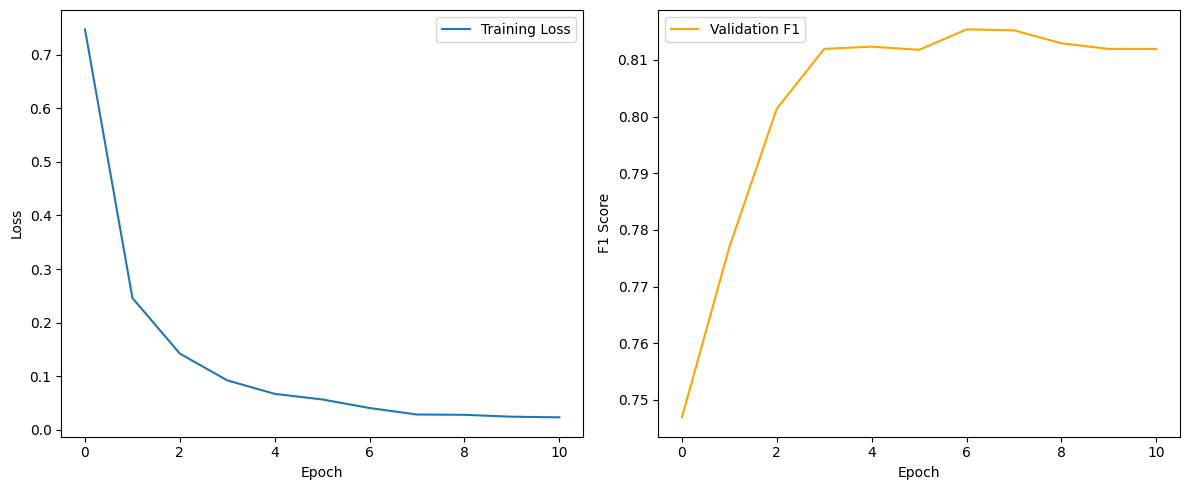

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_f1_scores, label='Validation F1', color='orange')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.tight_layout()
plt.savefig('bert_training_history.png')
plt.show()

Получаем результат чуть лучше, чем в предыдущий раз *(0.82 против 0.79)*  Weighted F1. Сохраним веса и выход, но все равно будем пробовать другие подходы

In [ ]:
model.load_state_dict(torch.load('best_bert_model.pth'))
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Final Weighted F1-Score: {final_f1:.4f}')

print(classification_report(all_labels, all_preds, target_names=le.classes_))

Final Weighted F1-Score: 0.8154
                        precision    recall  f1-score   support

            нет товара       0.80      0.78      0.79      1730
                одежда       0.86      0.89      0.87      4794
              текстиль       0.47      0.43      0.45       526
      товары для детей       0.00      0.00      0.00        11
украшения и аксессуары       0.52      0.32      0.39        97

              accuracy                           0.82      7158
             macro avg       0.53      0.48      0.50      7158
          weighted avg       0.81      0.82      0.82      7158



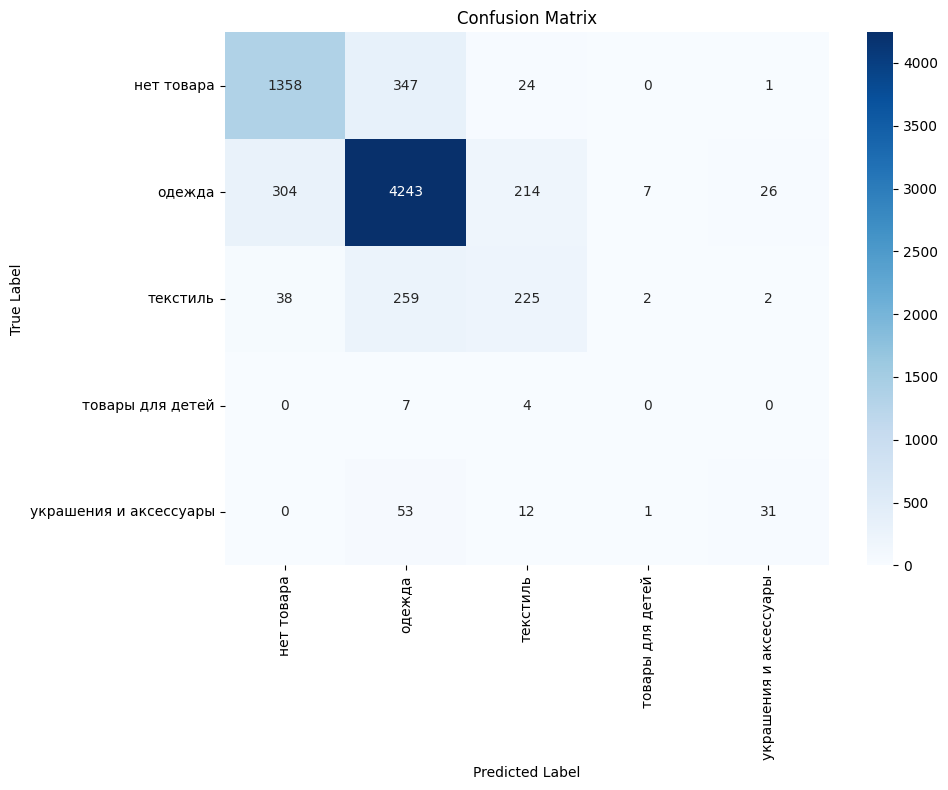

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('bert_confusion_matrix.png')
plt.show()

In [ ]:
#для теста делаем датасет без разметки
class TestUnlabeledDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

final_test_dataset = TestUnlabeledDataset(test_unlabeled_df['text'].values, tokenizer)
final_test_loader = DataLoader(final_test_dataset, batch_size=16, shuffle=False)

model.eval()
final_preds = []

with torch.no_grad():
    for batch in tqdm(final_test_loader, desc='Predicting'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, 1)
        final_preds.extend(preds.cpu().numpy())

test_unlabeled_df['predicted_category'] = le.inverse_transform(final_preds)
test_unlabeled_df[['text', 'predicted_category']].to_csv('bert_predictions.csv', index=False)

Predicting: 100%|██████████| 455/455 [00:09<00:00, 50.07it/s] 


Сразу можем оценить распределение категорий, чтобы *"на глаз"* оценить с тем, что видим в самих данных. Действительно, это совпадает с данными. Еще раз замечу, что для обучения оставлено **5 классов**, которые хотя бы 1 раз встречаются в датасете. Лишние категории ничем не помогут, так как в авторазметке они попадались по ошибки, а значит для модели они пойдут во вред и не помогут выделить эти категории в новых данных

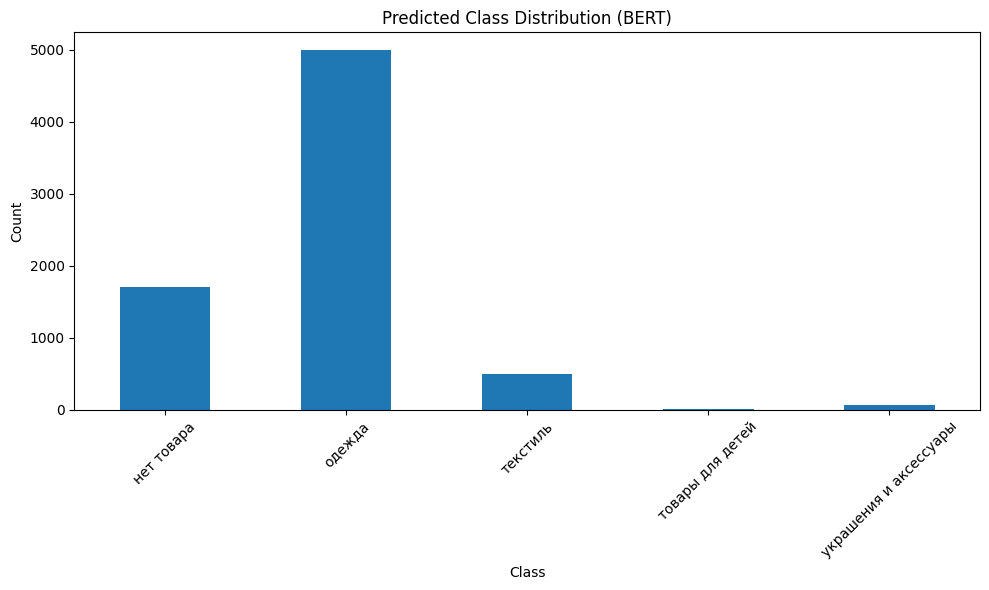

In [ ]:
class_distribution = pd.Series(final_preds).value_counts().sort_index()
class_distribution.index = le.inverse_transform(class_distribution.index)
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title('Predicted Class Distribution (BERT)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('bert_predicted_distribution.png')
plt.show()

#MLP

Дальше чисто ради эксперимента попробучем создать классический многослойный персептрон, но для эмбеддингов используем тот же **BERT**, то есть по сути сделаем `Feature Transfer`. Такая модель будет сильно чувствительна к дисбалансу, поэтому с помощью RandomOverSampler дополним малые категории

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    return ' '.join(tokens)

train_df = pd.read_csv('/content/drive/MyDrive/train_labeled.csv')
test_labeled_df = pd.read_csv('/content/drive/MyDrive/test_labeled.csv').reset_index()
test_unlabeled_df = pd.read_csv('/content/drive/MyDrive/test.csv').reset_index()

train_df = train_df[train_df['predicted_category'].isin(categories)]
test_df = pd.merge(test_unlabeled_df, test_labeled_df, on='index', how='inner')
test_df = test_df[test_df['predicted_category'].isin(categories)]

train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

le = LabelEncoder()
le.fit(categories)

train_texts = train_df['text'].values
train_labels = le.transform(train_df['predicted_category'].values)
test_texts = test_df['text'].values
test_labels = le.transform(test_df['predicted_category'].values)

In [ ]:
#после экспериментов эта модель показала себя лучше остальных
model_name = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name).to(device)

def get_bert_embeddings(texts, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating BERT embeddings"):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts.tolist(), return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

        with torch.no_grad():
            outputs = bert_model(**inputs)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

X_train = get_bert_embeddings(train_texts)
X_test = get_bert_embeddings(test_texts)

Generating BERT embeddings: 100%|██████████| 224/224 [00:02<00:00, 89.54it/s]


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, train_labels)

class_counts = Counter(y_train_res)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}

Также для борьбы с дисбалансом поможет кастомный функционал ошибки и веса для классов

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.X[idx]), torch.LongTensor([self.y[idx]])[0]

train_dataset = TextDataset(X_train_res, y_train_res)
test_dataset = TextDataset(X_test, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(MLPModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

input_dim = X_train.shape[1]
hidden_dim = 512
output_dim = len(categories)

model = MLPModel(input_dim, hidden_dim, output_dim).to(device)
alpha = torch.FloatTensor([class_weights[i] for i in range(len(class_weights))]).to(device)
criterion = FocalLoss(alpha=alpha, gamma=2)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

In [ ]:
#много эпох и ранняя остановка
num_epochs = 50
best_f1 = 0
patience = 5
patience_counter = 0

train_losses = []
val_f1_scores = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

    for X_batch, y_batch in progress_bar:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader, desc='Validating'):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    val_f1_scores.append(f1)

    scheduler.step(f1)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, F1: {f1:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')

    if f1 > best_f1:
        best_f1 = f1
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'New best F1: {best_f1:.4f}')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

Validating: 100%|██████████| 112/112 [00:00<00:00, 136.59it/s]


Epoch 1/50, Loss: 0.0003, F1: 0.7189, LR: 0.001000
New best F1: 0.7189


Validating: 100%|██████████| 112/112 [00:00<00:00, 207.05it/s]


Epoch 2/50, Loss: 0.0001, F1: 0.7222, LR: 0.001000
New best F1: 0.7222


Validating: 100%|██████████| 112/112 [00:00<00:00, 381.37it/s]


Epoch 3/50, Loss: 0.0001, F1: 0.7457, LR: 0.001000
New best F1: 0.7457


Validating: 100%|██████████| 112/112 [00:00<00:00, 446.04it/s]


Epoch 4/50, Loss: 0.0001, F1: 0.7486, LR: 0.001000
New best F1: 0.7486


Validating: 100%|██████████| 112/112 [00:00<00:00, 535.10it/s]


Epoch 5/50, Loss: 0.0001, F1: 0.7466, LR: 0.001000


Validating: 100%|██████████| 112/112 [00:00<00:00, 558.75it/s]


Epoch 6/50, Loss: 0.0000, F1: 0.7497, LR: 0.001000
New best F1: 0.7497


Validating: 100%|██████████| 112/112 [00:00<00:00, 573.49it/s]


Epoch 7/50, Loss: 0.0000, F1: 0.7448, LR: 0.001000


Validating: 100%|██████████| 112/112 [00:00<00:00, 531.43it/s]


Epoch 8/50, Loss: 0.0000, F1: 0.7635, LR: 0.001000
New best F1: 0.7635


Validating: 100%|██████████| 112/112 [00:00<00:00, 541.62it/s]


Epoch 9/50, Loss: 0.0000, F1: 0.7536, LR: 0.001000


Validating: 100%|██████████| 112/112 [00:00<00:00, 558.91it/s]


Epoch 10/50, Loss: 0.0000, F1: 0.7601, LR: 0.001000


Validating: 100%|██████████| 112/112 [00:00<00:00, 539.61it/s]


Epoch 11/50, Loss: 0.0000, F1: 0.7552, LR: 0.001000


Validating: 100%|██████████| 112/112 [00:00<00:00, 518.48it/s]


Epoch 12/50, Loss: 0.0000, F1: 0.7600, LR: 0.000500


Validating: 100%|██████████| 112/112 [00:00<00:00, 559.48it/s]

Epoch 13/50, Loss: 0.0000, F1: 0.7588, LR: 0.000500
Early stopping at epoch 13


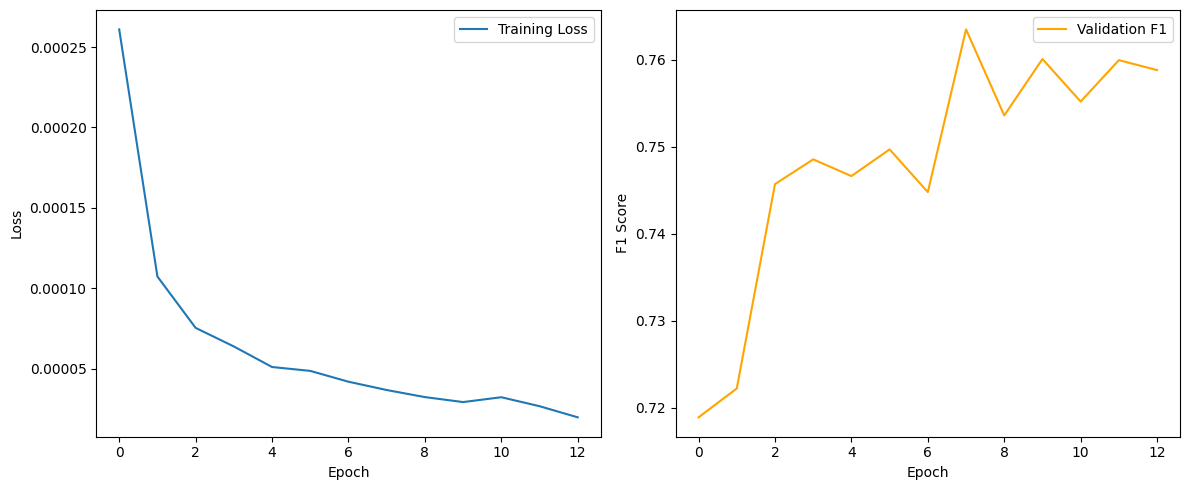

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_f1_scores, label='Validation F1', color='orange')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

Не удивительно, что обычное извлечение признаков не дало лучших результатов *(f1 0.76)*, но ради интереса стоило его попробовать, так как в данных многие отзывы содержат ключевые слова, которые выделяют их. Да и в целом смысл отзывов обычно находится на поверхности, поэтому качественными признаками их разделить возможно

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in tqdm(test_loader, desc='Testing'):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

final_f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Final Weighted F1-Score: {final_f1:.4f}')

print(classification_report(all_labels, all_preds, target_names=le.classes_))

Testing: 100%|██████████| 112/112 [00:00<00:00, 376.75it/s]


Final Weighted F1-Score: 0.7635
                        precision    recall  f1-score   support

            нет товара       0.72      0.72      0.72      1730
                одежда       0.84      0.83      0.84      4794
              текстиль       0.37      0.40      0.39       526
      товары для детей       0.10      0.18      0.13        11
украшения и аксессуары       0.15      0.10      0.12        97

              accuracy                           0.76      7158
             macro avg       0.44      0.45      0.44      7158
          weighted avg       0.76      0.76      0.76      7158



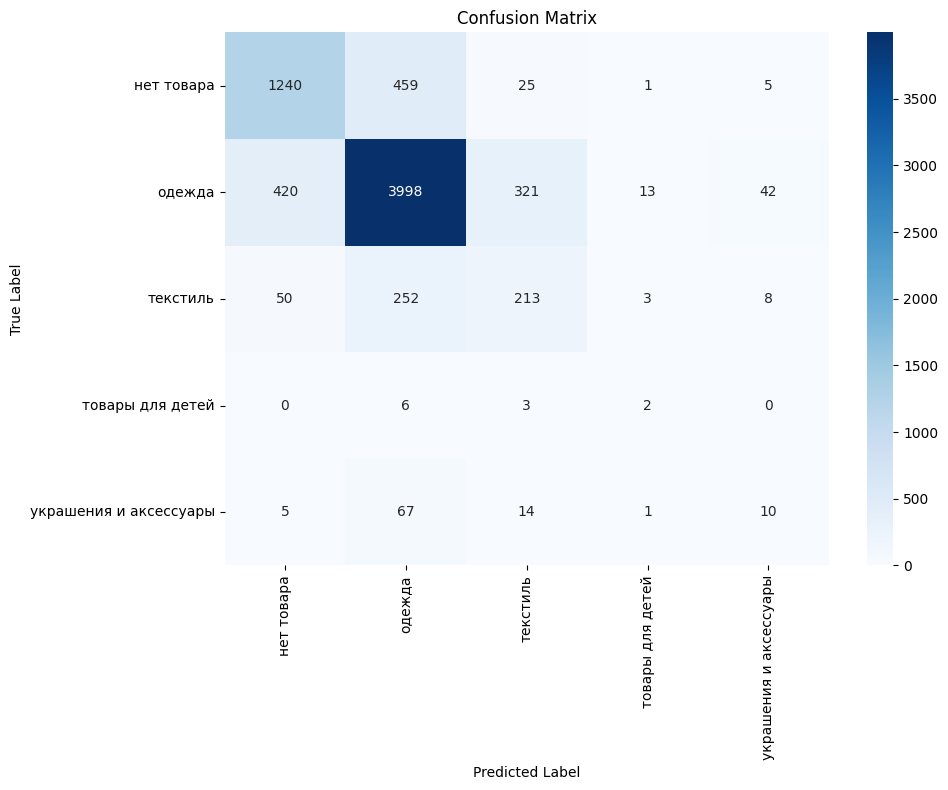

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

In [ ]:
test_unlabeled_df['text'] = test_unlabeled_df['text'].apply(preprocess_text)
X_final_test = get_bert_embeddings(test_unlabeled_df['text'].values)
X_final_test = scaler.transform(X_final_test)
final_test_dataset = TextDataset(X_final_test, np.zeros(len(test_unlabeled_df)))
final_test_loader = DataLoader(final_test_dataset, batch_size=64, shuffle=False)

model.eval()
final_preds = []

with torch.no_grad():
    for X_batch, _ in tqdm(final_test_loader, desc='Predicting'):
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        final_preds.extend(preds.cpu().numpy())

test_unlabeled_df['predicted_category'] = le.inverse_transform(final_preds)
test_unlabeled_df[['text', 'predicted_category']].to_csv('predictions.csv', index=False)

Predicting: 100%|██████████| 114/114 [00:00<00:00, 586.68it/s]


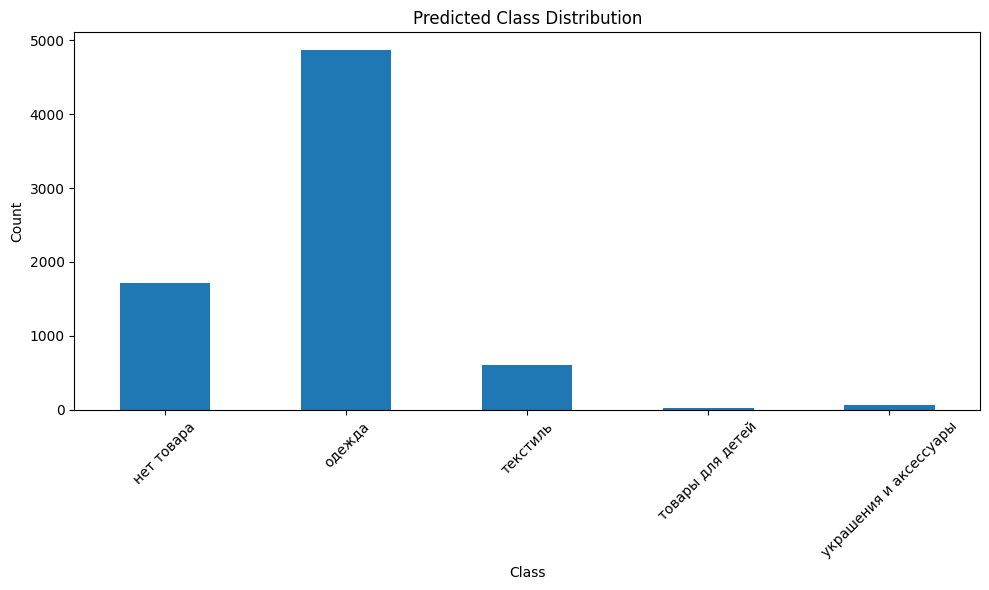

In [ ]:
class_distribution = pd.Series(final_preds).value_counts().sort_index()
class_distribution.index = le.inverse_transform(class_distribution.index)
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title('Predicted Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('predicted_distribution.png')
plt.show()

#LSTM
Интересно также попробовать **LSTM** модель, тексты не слишком длянные, поэтому такой подход тоже может показать результаты, хотя опять же странно будет его сравнивать с берт, в котором технологию 2018 года не удалось превзойти до настоящего времени. Подготовку данных оставим похожей на подход с MLP. В LSTM будем подавать эмбеддинги, а на выходе поставим слой классификации

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from imblearn.over_sampling import RandomOverSampler
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('russian'))

categories = [
    "одежда", "нет товара", "украшения и аксессуары",
    "товары для детей", "текстиль"
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    return ' '.join(tokens)

train_df = pd.read_csv('/content/drive/MyDrive/train_labeled.csv')
test_labeled_df = pd.read_csv('/content/drive/MyDrive/test_labeled.csv').reset_index()
test_unlabeled_df = pd.read_csv('/content/drive/MyDrive/test.csv').reset_index()

train_df = train_df[train_df['predicted_category'].isin(categories)]
test_df = pd.merge(test_unlabeled_df, test_labeled_df, on='index', how='inner')
test_df = test_df[test_df['predicted_category'].isin(categories)]

train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

In [ ]:
le = LabelEncoder()
le.fit(categories)

train_texts = train_df['text'].values
train_labels = le.transform(train_df['predicted_category'].values)
test_texts = test_df['text'].values
test_labels = le.transform(test_df['predicted_category'].values)

In [ ]:
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, train_labels)

class_counts = Counter(y_train_res)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[cls] for cls in y_train_res]

In [ ]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return torch.FloatTensor(self.X[idx].toarray()[0]), torch.LongTensor([self.y[idx]])[0]

train_dataset = TextDataset(X_train_res, y_train_res)
test_dataset = TextDataset(X_test, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers,
                           batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x).unsqueeze(1)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        out = self.fc(self.dropout(torch.cat((hidden[-2], hidden[-1]), dim=1)))
        return out

input_dim = X_train.shape[1]
hidden_dim = 256
output_dim = len(categories)

model = LSTMModel(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(list(class_weights.values())).to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    scheduler.step(total_loss / len(train_loader))

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, F1: {f1:.4f}')

Epoch 1/20, Loss: 0.7589, F1: 0.7405
Epoch 2/20, Loss: 0.0490, F1: 0.7439
Epoch 3/20, Loss: 0.0115, F1: 0.7468
Epoch 4/20, Loss: 0.0082, F1: 0.7492
Epoch 5/20, Loss: 0.0061, F1: 0.7492
Epoch 6/20, Loss: 0.0062, F1: 0.7504
Epoch 7/20, Loss: 0.0054, F1: 0.7493
Epoch 8/20, Loss: 0.0048, F1: 0.7487
Epoch 9/20, Loss: 0.0065, F1: 0.7362
Epoch 10/20, Loss: 0.0052, F1: 0.7427
Epoch 11/20, Loss: 0.0068, F1: 0.7518
Epoch 12/20, Loss: 0.0053, F1: 0.7504
Epoch 13/20, Loss: 0.0049, F1: 0.7516
Epoch 14/20, Loss: 0.0044, F1: 0.7455
Epoch 15/20, Loss: 0.0048, F1: 0.7520
Epoch 16/20, Loss: 0.0049, F1: 0.7515
Epoch 17/20, Loss: 0.0051, F1: 0.7523
Epoch 18/20, Loss: 0.0042, F1: 0.7511
Epoch 19/20, Loss: 0.0047, F1: 0.7494
Epoch 20/20, Loss: 0.0044, F1: 0.7490


Результаты слабые, но мы никак не дорабатывали модель, поэтому не будем скидывать со счетов этот подход и попробуем еще раз воспользоваться им

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

final_f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Final Weighted F1-Score: {final_f1:.4f}')

Final Weighted F1-Score: 0.7490


In [ ]:
test_unlabeled_df['text'] = test_unlabeled_df['text'].apply(preprocess_text)
X_final_test = vectorizer.transform(test_unlabeled_df['text'].values)
final_test_dataset = TextDataset(X_final_test, np.zeros(len(test_unlabeled_df)))
final_test_loader = DataLoader(final_test_dataset, batch_size=64, shuffle=False)

model.eval()
final_preds = []

with torch.no_grad():
    for X_batch, _ in final_test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        final_preds.extend(preds.cpu().numpy())

test_unlabeled_df['predicted_category'] = le.inverse_transform(final_preds)
test_unlabeled_df[['text', 'predicted_category']].to_csv('predictions.csv', index=False)

#BERT+LSTM

В конце попробуем самое интересное: взять и совместить оба подхода. В этот раз в LSTM подадим эмбеддинги, созданные с помощью `энкодера`

In [ ]:
%pip install transforms torch datasets imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 7.6 MB/s eta 0:00:00


In [ ]:
import re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score
from imblearn.over_sampling import RandomOverSampler
from transformers import AutoModel, AutoTokenizer, get_scheduler
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
import nltk

/usr/local/lib/python3.12/dist-packages/torch_xla/experimental/gru.py:113: SyntaxWarning: invalid escape sequence '\_'
  * **h_n**: tensor of shape :math:`(D * \text{num\_layers}, H_{out})` or


In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

class BertLSTMClassifier(nn.Module):
    def __init__(self, model_name, num_classes, freeze_bert=False, hidden_dim=512, lstm_layers=2, dropout=0.6, use_attention=True, bidirectional=True):
        super(BertLSTMClassifier, self).__init__()

        self.bert = AutoModel.from_pretrained(model_name)
        self.bert_hidden_size = self.bert.config.hidden_size

        #попробучем использовать берт и просто для извлечения признаков, и в процессе обучения
        self.freeze_bert = freeze_bert
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

        self.lstm = nn.LSTM(
            input_size=self.bert_hidden_size,
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if lstm_layers > 1 else 0
        )

        #в качестве дополнения перед классификатором еще один слой внимания
        self.use_attention = use_attention
        if use_attention:
            self.attention = nn.Sequential(
                nn.Linear(hidden_dim * (2 if bidirectional else 1), hidden_dim),
                nn.Tanh(),
                nn.Linear(hidden_dim, 1),
                nn.Softmax(dim=1)
            )

        self.layer_norm = nn.LayerNorm(hidden_dim * (2 if bidirectional else 1))
        self.dropout = nn.Dropout(dropout)
        linear_input_size = hidden_dim * (2 if bidirectional else 1)
        self.classifier = nn.Sequential(
            nn.Linear(linear_input_size, linear_input_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(linear_input_size // 2, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        if self.freeze_bert:
            with torch.no_grad():
                outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        else:
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        sequence_output = outputs.last_hidden_state

        lstm_output, (hidden, cell) = self.lstm(sequence_output)

        if self.use_attention:
            attention_weights = self.attention(lstm_output)
            context_vector = torch.sum(attention_weights * lstm_output, dim=1)
        else:
            if self.lstm.bidirectional:
                hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
                context_vector = hidden
            else:
                context_vector = hidden[-1, :, :]

        context_vector = self.layer_norm(context_vector)
        context_vector = self.dropout(context_vector)
        logits = self.classifier(context_vector)

        return logits

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
def create_data_loaders(texts, labels, tokenizer, batch_size=16, max_length=256):
    dataset = TextClassificationDataset(texts, labels, tokenizer, max_length)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

def compute_metrics(predictions, labels):
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return accuracy, f1

In [ ]:
def train_model(model, train_loader, val_loader, device, num_epochs=15, learning_rate=2e-5, patience=3, weight_decay=0.01, gradient_accumulation_steps=2):
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
    num_training_steps = num_epochs * len(train_loader) // gradient_accumulation_steps
    num_warmup_steps = num_training_steps // 10

    scheduler = get_scheduler(
        "cosine",
        optimizer=optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )

    best_val_loss = float('inf')
    best_accuracy = 0
    patience_counter = 0

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_f1': [], 'val_f1': []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 50)

        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []

        optimizer.zero_grad()

        train_progress = tqdm(train_loader, desc="Training", leave=False)
        for i, batch in enumerate(train_progress):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = F.cross_entropy(outputs, labels)
            loss = loss / gradient_accumulation_steps
            loss.backward()

            if (i + 1) % gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            train_loss += loss.item() * gradient_accumulation_steps
            _, preds = torch.max(outputs, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

            train_progress.set_postfix({
                'loss': f'{loss.item() * gradient_accumulation_steps:.4f}',
                'lr': f'{scheduler.get_last_lr()[0]:.2e}'
            })

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy, train_f1 = compute_metrics(train_preds, train_labels)

        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []

        val_progress = tqdm(val_loader, desc="Validation", leave=False)
        with torch.no_grad():
            for batch in val_progress:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = F.cross_entropy(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

                val_progress.set_postfix({
                    'loss': f'{loss.item():.4f}'
                })

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy, val_f1 = compute_metrics(val_preds, val_labels)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_accuracy)
        history['val_acc'].append(val_accuracy)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)

        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Train F1: {train_f1:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f} | Val F1: {val_f1:.4f}")

        if val_accuracy > best_accuracy and avg_val_loss < best_val_loss:
            best_accuracy = val_accuracy
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Model improved! Saved with accuracy: {best_accuracy:.4f} and loss: {best_val_loss:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"No improvement. Patience: {patience_counter}/{patience}")

            if patience_counter >= patience:
                print("Early stopping triggered")
                break

        if epoch == 2 and FREEZE_BERT:
            print("Unfreezing BERT layers")
            for param in model.bert.parameters():
                param.requires_grad = True
            model.freeze_bert = False

    model.load_state_dict(torch.load('best_model.pth'))
    print(f"\nBest model with accuracy: {best_accuracy:.4f} and loss: {best_val_loss:.4f}")

    return model, history, val_preds, val_labels

def predict(model, tokenizer, texts, device, batch_size=16, max_length=256):
    model.eval()
    predictions = []
    probabilities = []

    dataset = TextClassificationDataset(texts, [0]*len(texts), tokenizer, max_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Prediction"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())

    return predictions, probabilities

In [ ]:
def plot_training_history(history):
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Validation Loss')
    axes[0].set_title('Loss over Epochs')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(history['train_acc'], label='Train Accuracy')
    axes[1].plot(history['val_acc'], label='Validation Accuracy')
    axes[1].set_title('Accuracy over Epochs')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
MODEL_NAME = "cointegrated/rubert-tiny2"
BATCH_SIZE = 16
MAX_LENGTH = 256
NUM_EPOCHS = 15
LEARNING_RATE = 2e-5
HIDDEN_DIM = 512
FREEZE_BERT = False
DROPOUT_RATE = 0.3
PATIENCE = 3
WEIGHT_DECAY = 0.01
GRADIENT_ACCUMULATION_STEPS = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

stop_words = set(stopwords.words('russian'))

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    return ' '.join(tokens)

categories = [
    "одежда", "нет товара", "украшения и аксессуары",
    "товары для детей", "текстиль"
]

train_df = pd.read_csv('/content/drive/MyDrive/train_labeled.csv')
test_labeled_df = pd.read_csv('/content/drive/MyDrive/test_labeled.csv').reset_index()
test_unlabeled_df = pd.read_csv('/content/drive/MyDrive/test.csv').reset_index()

train_df = train_df[train_df['predicted_category'].isin(categories)]
test_df = pd.merge(test_unlabeled_df, test_labeled_df, on='index', how='inner')
test_df = test_df[test_df['predicted_category'].isin(categories)]

train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

le = LabelEncoder()
le.fit(categories)

train_texts = train_df['text'].values
train_labels = le.transform(train_df['predicted_category'].values)
test_texts = test_df['text'].values
test_labels = le.transform(test_df['predicted_category'].values)

ros = RandomOverSampler(random_state=42)
train_texts_resampled, train_labels_resampled = ros.fit_resample(
    train_texts.reshape(-1, 1),
    train_labels
)
train_texts_resampled = train_texts_resampled.squeeze()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_loader = create_data_loaders(
    train_texts_resampled, train_labels_resampled, tokenizer,
    batch_size=BATCH_SIZE, max_length=MAX_LENGTH
)

val_loader = create_data_loaders(
    test_texts, test_labels, tokenizer,
    batch_size=BATCH_SIZE, max_length=MAX_LENGTH
)

NUM_CLASSES = len(np.unique(train_labels_resampled))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
model = BertLSTMClassifier(
    model_name=MODEL_NAME,
    num_classes=NUM_CLASSES,
    freeze_bert=FREEZE_BERT,
    hidden_dim=HIDDEN_DIM,
    dropout=DROPOUT_RATE
)
model.to(device)

trained_model, history, val_preds, val_labels = train_model(
    model, train_loader, val_loader, device,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    patience=PATIENCE,
    weight_decay=WEIGHT_DECAY,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)


Epoch 1/15
--------------------------------------------------


Training:   0%|          | 0/379 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Train Loss: 1.3201 | Train Acc: 0.4696 | Train F1: 0.4655
Val Loss: 1.0373 | Val Acc: 0.5820 | Val F1: 0.6360
Model improved! Saved with accuracy: 0.5820 and loss: 1.0373

Epoch 2/15
--------------------------------------------------


Training:   0%|          | 0/379 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Train Loss: 0.4964 | Train Acc: 0.8327 | Train F1: 0.8292
Val Loss: 0.6592 | Val Acc: 0.7266 | Val F1: 0.7451
Model improved! Saved with accuracy: 0.7266 and loss: 0.6592

Epoch 3/15
--------------------------------------------------


Training:   0%|          | 0/379 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Train Loss: 0.2231 | Train Acc: 0.9234 | Train F1: 0.9224
Val Loss: 0.6637 | Val Acc: 0.7552 | Val F1: 0.7685
No improvement. Patience: 1/3

Epoch 4/15
--------------------------------------------------


Training:   0%|          | 0/379 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Train Loss: 0.1338 | Train Acc: 0.9571 | Train F1: 0.9566
Val Loss: 0.6550 | Val Acc: 0.7909 | Val F1: 0.7916
Model improved! Saved with accuracy: 0.7909 and loss: 0.6550

Epoch 5/15
--------------------------------------------------


Training:   0%|          | 0/379 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Train Loss: 0.0898 | Train Acc: 0.9698 | Train F1: 0.9696
Val Loss: 0.7836 | Val Acc: 0.8006 | Val F1: 0.7969
No improvement. Patience: 1/3

Epoch 6/15
--------------------------------------------------


Training:   0%|          | 0/379 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Train Loss: 0.0646 | Train Acc: 0.9810 | Train F1: 0.9809
Val Loss: 0.9068 | Val Acc: 0.7913 | Val F1: 0.7925
No improvement. Patience: 2/3

Epoch 7/15
--------------------------------------------------


Training:   0%|          | 0/379 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Train Loss: 0.0421 | Train Acc: 0.9878 | Train F1: 0.9878
Val Loss: 0.9920 | Val Acc: 0.8023 | Val F1: 0.7955
No improvement. Patience: 3/3
Early stopping triggered

Best model with accuracy: 0.7909 and loss: 0.6550


##Результаты
Модель явно переобучилась из-за своей сложности, но показала неплохой результат. Сейчас я уже не успею ее доработать, но как хорошую идею оставлю здесь

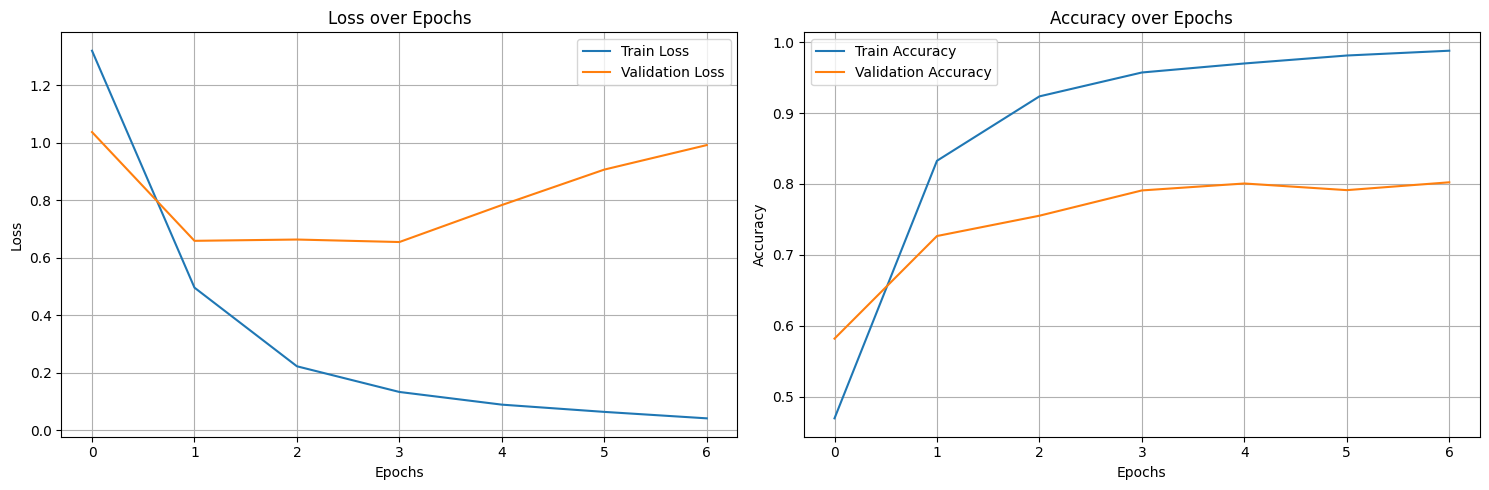

In [ ]:
plot_training_history(history)

In [ ]:
val_preds_categorical = le.inverse_transform(val_preds)
val_labels_categorical = le.inverse_transform(val_labels)

print("Classification Report:")
print(classification_report(val_labels_categorical, val_preds_categorical, target_names=categories))

Classification Report:
                        precision    recall  f1-score   support

                одежда       0.79      0.72      0.75      1730
            нет товара       0.84      0.89      0.86      4794
украшения и аксессуары       0.47      0.35      0.40       526
      товары для детей       0.00      0.00      0.00        11
              текстиль       0.40      0.29      0.34        97

              accuracy                           0.80      7158
             macro avg       0.50      0.45      0.47      7158
          weighted avg       0.79      0.80      0.80      7158

